# [Tutorial] LSTM을 이용한 단시간 하천 수위 예측 

## 1. 바로실습해보기 
  - 바인더 아이콘을 클릭하면, 주피터 노트북 환경에서 코드를 실습할 수 있습니다.
  - 바인더 환경구성에 약 5분이 소요되며, 본 실습코드의 경우 바인더보다는 GPU환경에서 실습하기를 권장합니다.

## 2. 입력 데이터
  - WAMIS에서 제공중인 OpenAPI를 이용하여 수위 및 강우데이터를 수집하여 데이터셋 제공
    - 수집기간 : '14.1월 ~ '21.6월
    - 수집지역 : (수위) 남양주시 부평교, 내곡교, 진관교 (강우) 진관교, 진접읍사무소
  
## 3. 알고리즘 - LSTM(Long Short Term Memory)
  - LSTM은 RNN의 특별한 한 종류로, 긴 의존 기간을 필요로 하는 학습을 수행할 능력을 갖고 있다. LSTM은 Hochreiter & Schmidhuber (1997)에 의해 소개되었고, 그 후에 여러 추후 연구로 계속 발전하고 유명해졌다. LSTM은 여러 분야의 문제를 굉장히 잘 해결했고, 지금도 널리 사용되고 있다.

## 4. Tutoral 주요 내용
  - 진관교 및 상류지역 수위 및 강우데이터를 이용하여 1시간후 진관교 수위를 예측베이스 코드 제공
    - '21년 K-water 빅데이터 콘테스트 과제를 재구성함
    - 기본 코드를 제공하는데 목적이 있으며, 성능 향상을 위해서는 다양한 딥러닝 기법이 추가되어야 함
  - 딥러닝 알고리즘을 이용하기 위한 시계열 데이터 전처리
  - LSTM 모형 훈련 및 예측

In [1]:
# 라이브러리 임포트
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/frame

## Step1. 데이터 읽기
 - /data 폴더에서 수위 및 강우 데이터를 읽어, 입력데이터로 구성합니다.

In [2]:
# 14년1월 ~ 21년 6월까지 데이터를 활용
# openAPI를 통해 6개월 단위로 수집가능함에 따라, 병합처리 필요

path = './data/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [3]:
# 진관교 및 상류지역 수위 및 강우량 지점 코드 
# 해당 코드명이 파일 이름으로 포함되어 있음

raw_obscd = {'obscd': ['1018620', '1018625', '1018630', '10184110', '10184220'],
            'desc': ['수위_남양주시 부평교', '수위_남양주시 내곡교', '수위_남양주시 진관교', '강우_진관교', '강우_진접읍사무소']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd


,obscd,desc
0,1018620,수위_남양주시 부평교
1,1018625,수위_남양주시 내곡교
2,1018630,수위_남양주시 진관교
3,10184110,강우_진관교
4,10184220,강우_진접읍사무소


In [4]:
# 기준이 되는 Date를 생성함

start = datetime.datetime.strptime("2015050101", "%Y%m%d%H")
end = datetime.datetime.strptime("2020110123", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2015-05-01 01:00:00,2015050101
1,2015-05-01 02:00:00,2015050102
2,2015-05-01 03:00:00,2015050103
3,2015-05-01 04:00:00,2015050104
4,2015-05-01 05:00:00,2015050105
...,...,...
48282,2020-11-01 19:00:00,2020110119
48283,2020-11-01 20:00:00,2020110120
48284,2020-11-01 21:00:00,2020110121
48285,2020-11-01 22:00:00,2020110122


In [5]:
# 앞에서 만든 데이터프레임을 이용하여, 각 파일들을 읽고 합치는 작업을 함

for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['./data/wl_1018620_20140101_20140630.csv', './data/wl_1018620_20140701_20141231.csv', './data/wl_1018620_20150101_20150630.csv', './data/wl_1018620_20150701_20151231.csv', './data/wl_1018620_20160101_20160630.csv', './data/wl_1018620_20160701_20161231.csv', './data/wl_1018620_20170101_20170630.csv', './data/wl_1018620_20170701_20171231.csv', './data/wl_1018620_20180101_20180630.csv', './data/wl_1018620_20180701_20181231.csv', './data/wl_1018620_20190101_20190630.csv', './data/wl_1018620_20190701_20191231.csv', './data/wl_1018620_20200101_20200630.csv', './data/wl_1018620_20200701_20201231.csv', './data/wl_1018620_20210101_20210630.csv']
['./data/wl_1018625_20140101_20140630.csv', './data/wl_1018625_20140701_20141231.csv', './data/wl_1018625_20150101_20150630.csv', './data/wl_1018625_20150701_20151231.csv', './data/wl_1018625_20160101_20160630.csv', './data/wl_1018625_20160701_20161231.csv', './data/wl_1018625_20170101_20170630.csv', './data/wl_1018625_20170701_20171231.csv', './data/w

## Step2. 결측치 확인 및 데이터 전처리
  - 결측치를 확인하고, 결측구간이 1인 경우 선형보간을 적용합니다.
  - 결측구간이 2이상인 경우는 훈련 데이터에서 제외합니다.

<AxesSubplot:>

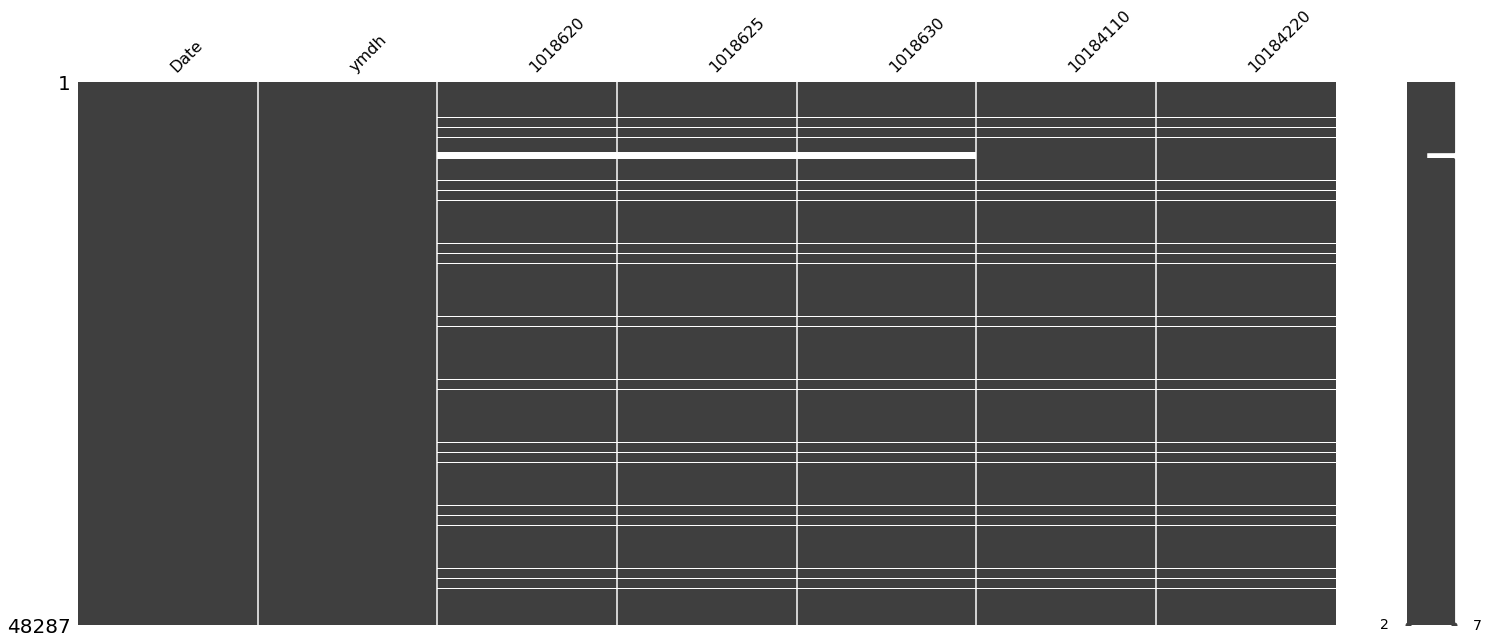

In [6]:
# 결측치 시각화 및 확인
import missingno as msno
msno.matrix(df)

In [7]:
# 결측치는 선형보간으로 처리
# LSTM의 경우 연속된 값을 입력으로 해야함에 따라 결측치 보간을 필수적으로 해야함

df['1018620'] = df['1018620'].interpolate(limit = 1)
df['1018625'] = df['1018625'].interpolate(limit = 1)
df['1018630'] = df['1018630'].interpolate(limit = 1)
df['10184110'] = df['10184110'].fillna(0)
df['10184220'] = df['10184220'].fillna(0)
# 보간 참고

<AxesSubplot:>

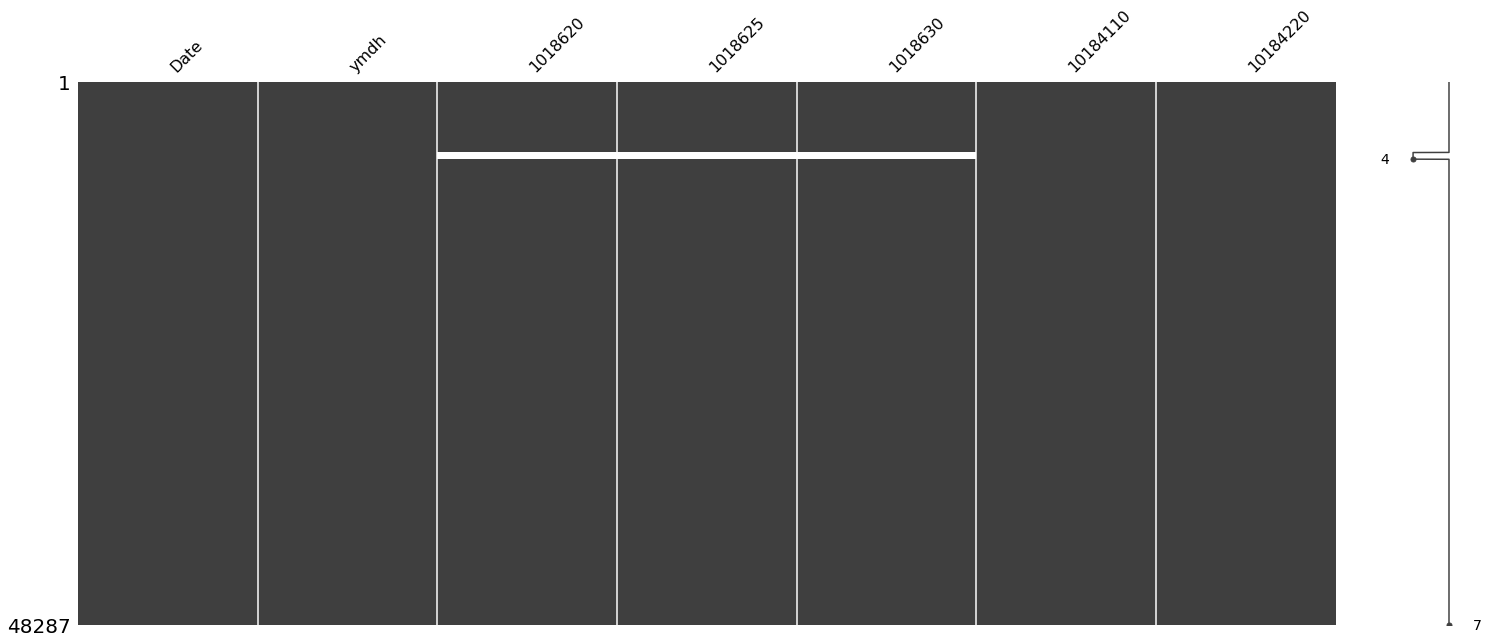

In [8]:
# 선형보간 결과 확인
msno.matrix(df)

In [9]:
df.isnull().sum()

Date          0
ymdh          0
1018620     600
1018625     600
1018630     600
10184110      0
10184220      0
dtype: int64

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
46103,2020-08-03 00:00:00,2020080300,1.16,1.645,1.135,0.0,0.0
46104,2020-08-03 01:00:00,2020080301,1.14,1.620,1.130,1.0,0.0
46105,2020-08-03 02:00:00,2020080302,1.15,1.610,1.090,0.0,5.0
46106,2020-08-03 03:00:00,2020080303,1.38,1.620,1.090,13.0,6.0
46107,2020-08-03 04:00:00,2020080304,1.41,1.780,1.200,8.0,1.0
46108,2020-08-03 05:00:00,2020080305,1.43,1.900,1.440,10.0,12.0
46109,2020-08-03 06:00:00,2020080306,1.71,2.100,1.700,15.0,7.0
46110,2020-08-03 07:00:00,2020080307,1.59,2.550,2.170,10.0,16.0
46111,2020-08-03 08:00:00,2020080308,1.49,2.350,2.000,2.0,8.0
46112,2020-08-03 09:00:00,2020080309,1.80,2.530,1.990,22.0,20.0


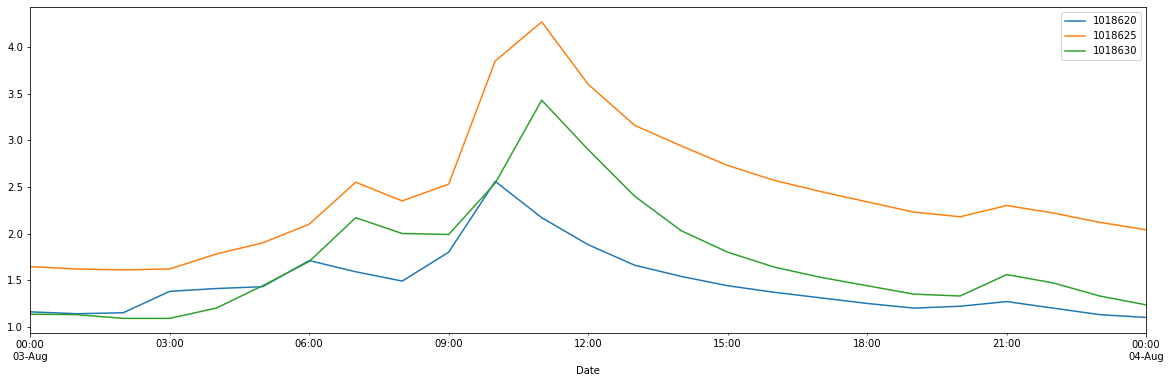

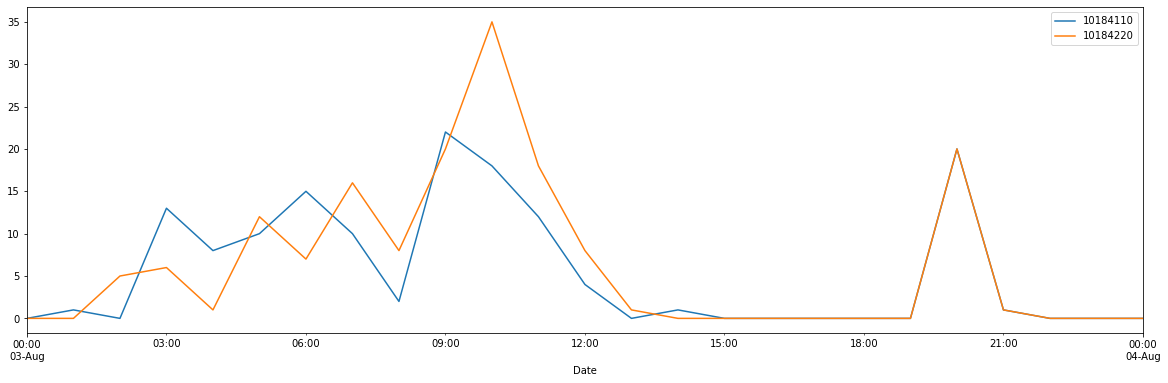

In [10]:
# 데이터 구조 체크 및 시각화

start = 2020080300
end = 2020080400

df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '1018620', '1018625', '1018630']].set_index('Date')
df_temp.plot(figsize=(20,6))
df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '10184110', '10184220']].set_index('Date')
df_temp.plot(figsize=(20,6))

display(df[(df['ymdh'] >= start) & (df['ymdh'] <= end)])

In [13]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['Date', 'ymdh']).copy()
df_in

,1018620,1018625,1018630,10184110,10184220
0,0.20,1.08,-0.21,0.0,0.0
1,0.20,1.08,-0.21,0.0,0.0
2,0.20,1.08,-0.21,0.0,0.0
3,0.20,1.08,-0.22,0.0,0.0
4,0.20,1.08,-0.22,0.0,0.0
...,...,...,...,...,...
48282,0.15,1.07,-0.11,0.0,0.0
48283,0.15,1.07,-0.11,0.0,0.0
48284,0.15,1.07,-0.10,0.0,0.0
48285,0.15,1.08,-0.10,0.0,0.0


In [14]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

df_in_scaled


,1018620,1018625,1018630,10184110,10184220
0,0.063492,0.137838,0.026738,0.0,0.0
1,0.063492,0.137838,0.026738,0.0,0.0
2,0.063492,0.137838,0.026738,0.0,0.0
3,0.063492,0.137838,0.024064,0.0,0.0
4,0.063492,0.137838,0.024064,0.0,0.0
...,...,...,...,...,...
48282,0.043651,0.135135,0.053476,0.0,0.0
48283,0.043651,0.135135,0.053476,0.0,0.0
48284,0.043651,0.135135,0.056150,0.0,0.0
48285,0.043651,0.137838,0.056150,0.0,0.0


In [15]:
# 240시간(10일)에 대해 8개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1시간을 예측으로 함

x_range = 240
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = '1018630'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(47207, 240, 5)
[[[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]]

 [[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]]

 [[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13

In [16]:
# 50000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:30000,:,:]
X_val = dataset_X_reshaped[30000:40000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:30000]
y_val = dataset_y_reshaped[30000:40000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 240, 5)
(7207, 240, 5)
(30000, 1)
(7207, 1)


In [25]:
# Binder 환경에서 코드 실행시
X_train = dataset_X_reshaped[0:3000,:,:]
X_val = dataset_X_reshaped[3000:4000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:3000]
y_val = dataset_y_reshaped[3000:4000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3000, 240, 5)
(7207, 240, 5)
(3000, 1)
(7207, 1)


## Step3. LSTM 예측 모형 훈련
  - 기본 lstm모형에 대한 훈련 코드를 제공합니다.
  - Stacked LSTM을 Binder에서 학습할 경우 학습시간이 상당히 오래 걸리므로
  - Binder 보다는 GPU를 사용할 수 있는 환경을 추천하며, 본 코드는 데이터 전처리 등에 대한 확인 위주로 활용하는 것을 추천

In [ ]:
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 1로 설정되어 있음

drop_out_rate = 0.1

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(256, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x = LSTM(256, recurrent_dropout=drop_out_rate)(x) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 100
  es = EarlyStopping(monitor='val_loss', mode='min', patience=1, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=64)
  return model
 
model_base = base_lstm(X_train, y_train)

## Step4. 예측 및 시각화
  - 모형 학습 후, 1시간 후 수위 예측결과를 시각화

In [ ]:
# 테스트 데이터셋에서 수위가 가장높았던 상위 10개 시점의 인덱스를 구함
idx = (-y_test).argsort(axis=None)[:10]
idx

In [ ]:
# 위에서 뽑은 인덱스로 데이터셋을 구성
X_test_high_top10 = X_test[np.array(idx)]
y_test_high_top10 = y_test[np.array(idx)]

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
preds = model_base.predict(X_test_high_top10)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : preds.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(preds.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

In [ ]:
# 예측 수행
strix = 45982
num = 200

preds = model_base.predict(X_test[4900:5100])

df_pred = pd.DataFrame({'Date' : df['Date'][strix:strix+num].values, 'Obs' : y_test[4900:5100].flatten(), 'Pred' : preds.flatten()})
df_pred

In [ ]:
# 예측결과 시각화
df_pred[['Date', 'Obs', 'Pred']][100:200].set_index('Date').plot(figsize=(20,6))